# BIOSTAT 626 Project: Machine Learning Project

### Predicting Cancer Patient Survival Time by Using Cellular or Subcellular Resolution Spatial Proteomics Data
#### Group 16: Hyeonji Ha, Seungseok, Lee, Sooyeon Oh

## import library

In [ ]:
from typing import NewType
import argparse
import os
import shutil
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
from torch.utils.data.sampler import SubsetRandomSampler as Subset
from copy import deepcopy
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fix Seed deterministic model

In [ ]:
# Fix seed
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Use CUDA

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
momemtum = 0.9

## Dataset

### Data preprocessing
### Load images to tensor

In [ ]:
import torch
import pandas as pd
import tifffile as tiff
import numpy as np

# Load the CSV file
labels_df = pd.read_csv('/content/drive/MyDrive/pro626/train/train_data.csv')

# Assuming the TIFF files are named with their patient ID and stored in 'images/' directory
image_path = f'/content/drive/MyDrive/pro626/train/images'
def load_tiff_images_to_tensor(num_patients, num_channels=52, image_size=(150, 150), base_path='', start_num = 0):
    # Initialize a tensor to hold the image data
    images_tensor = torch.zeros((num_patients, num_channels, *image_size))

    for patient_id in range(1, num_patients + 1):  # Assuming IDs start from 1
        # Dynamically generate the image path for each patient_id
        image_path = f'{base_path}/{patient_id + start_num}.tiff'
        image_data = tiff.imread(image_path)  # This loads the multi-channel image
        image_tensor = torch.from_numpy(image_data).float()
        images_tensor[patient_id - 1] = image_tensor

    return images_tensor

# Load images into a tensor
num_patients = 225  # Total number of patients
images_tensor = load_tiff_images_to_tensor(num_patients, base_path = image_path)

# Check if the tensor dimensions match your expectation
print(images_tensor.shape)  # Should print torch.Size([225, 52, 150, 150])


torch.Size([225, 52, 150, 150])


In [ ]:
images_tensor.shape

torch.Size([225, 52, 150, 150])

### Gaussian Blur

In [ ]:
import torch
import torch.nn as nn
import math

class GaussianBlur(nn.Module):
    def __init__(self, kernel_size, sigma, in_channels):
        super(GaussianBlur, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.in_channels = in_channels
        self.padding = kernel_size // 2
        self.kernel = self.create_kernel(kernel_size, sigma, in_channels)

    def create_kernel(self, kernel_size, sigma, in_channels):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

        mean = (kernel_size - 1) / 2.
        variance = sigma ** 2.

        # Calculate the 2-dimensional gaussian kernel
        gaussian_kernel = (1. / (2. * math.pi * variance)) * \
                          torch.exp(
                              -torch.sum((xy_grid - mean) ** 2., dim=-1) / \
                              (2 * variance)
                          )
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(in_channels, 1, 1, 1)

        gaussian_filter = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size,
                                    groups=in_channels, bias=False, padding=self.padding)

        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False

        return gaussian_filter

    def forward(self, x):
        return self.kernel(x)

gaussian_blur = GaussianBlur(kernel_size=5, sigma=1.0, in_channels=52)
# images_tensor_blurred = gaussian_blur(images_tensor_normalized)


In [ ]:
images_tensor_blurred = gaussian_blur(images_tensor)

### Labels

In [ ]:
# Convert survival times into a tensor
survival_times = torch.tensor(labels_df['OSmonth'].values).float()

# Each image tensor at index i corresponds to the survival time at index i in survival_times


### Denoising
#### Checking channels which have low variance.


tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True, False],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True])


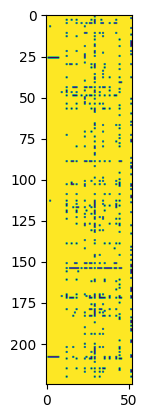

In [ ]:
import torch

def calculate_channel_presence(images_tensor):
    """
    Calculate a channel presence indicator for a batch of multi-channel images.

    Args:
    - images_tensor (torch.Tensor): A tensor of shape (num_samples, num_channels, height, width)
      containing the image data.

    Returns:
    - torch.Tensor: A Boolean tensor of shape (num_samples, num_channels) where True indicates
      a channel is present (non-blank) for a given image, and False indicates it is missing (blank).
    """
    # Assuming a channel is considered missing if its variance across spatial dimensions is zero
    # Calculate the variance of each channel in each image
    var_per_channel_per_image = torch.var(images_tensor, dim=[2, 3], keepdim=False)

    # A channel is considered present if its variance is greater than a small threshold (to account for numerical precision issues)
    threshold = 9e-2
    # threshold = 5e-2
    channel_presence = var_per_channel_per_image > threshold

    return channel_presence

# Example usage:
# num_samples = 10  # Assuming 10 images
# num_channels = 51  # 51 channels per your project description
# image_height, image_width = 150, 150  # Image dimensions

# # Generate a dummy tensor for demonstration purposes
# # In practice, this would be your images_tensor loaded from your actual data
# images_tensor = torch.randn(num_samples, num_channels, image_height, image_width)

# Calculate the channel presence indicator
channel_presence_indicator = calculate_channel_presence(images_tensor)

print(channel_presence_indicator)
plt.imshow(channel_presence_indicator)
print(channel_presence_indicator[11])
# plt.imshow(channel_presence_indicator[151], cmap='gray')

#### Imputing Channel with zero

In [ ]:
def zero_impute_channels(images_tensor, channel_presence_indicator):
    """
    Impute missing (blank) channels by setting them to zero.

    Args:
    - images_tensor (torch.Tensor): A tensor of shape (num_samples, num_channels, height, width)
      containing the image data.
    - channel_presence_indicator (torch.Tensor): A Boolean tensor of shape (num_samples, num_channels)
      where True indicates a channel is present (non-blank) for a given image, and False indicates it is missing (blank).

    Returns:
    - torch.Tensor: A tensor with the missing channels set to zero.
    """
    # Create a mask for missing channels (False in the indicator)
    missing_channel_mask = ~channel_presence_indicator

    # Expand the mask to match the dimensions of images_tensor
    # This requires repeating the mask across the height and width dimensions
    height, width = images_tensor.shape[2], images_tensor.shape[3]
    expanded_mask = missing_channel_mask.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, height, width)

    # Set missing channels to zero
    images_tensor[expanded_mask] = 0.0

    return images_tensor

# Apply zero imputation to the images_tensor
zero_imputed_tensor = zero_impute_channels(images_tensor, channel_presence_indicator)
# # plt.imshow(zero_imputed_tensor[11][23], cmap='gray')
# plt.imshow(images_tensor[11][23], cmap='gray')

# Check the tensor after imputation
# print(zero_imputed_tensor)

### Normalizaiton

In [ ]:
# Normalize the images tensor to have mean=0 and std=1
# Calculate the mean and std if not already known. Here, assuming the need to calculate:
mean = zero_imputed_tensor.mean()
std = zero_imputed_tensor.std()

# Normalize
images_tensor_normalized = (zero_imputed_tensor - mean) / std

print(f"Mean: {mean}, Std: {std}")


Mean: 14.865781784057617, Std: 86.05052185058594


### Creating Dataset From Tensor

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create a dataset from tensors
full_dataset = TensorDataset(images_tensor_normalized, survival_times)


### Transformer

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomApply([transforms.GaussianBlur(3)]),
])


### Transform dataset to Channel wise dataset

In [ ]:
class SingleChannelDataset(Dataset):
    def __init__(self, full_dataset, channel_index, transform=None, indices=None):
        """
        Args:
            full_dataset (Dataset): The complete dataset containing both images_tensor and labels.
            channel_index (int): The index of the channel to use.
            transform (callable, optional): Optional transform to be applied on a sample.
            indices (list of int, optional): List of indices to use from the full_dataset.
        """
        self.full_dataset = full_dataset
        self.channel_index = channel_index
        self.transform = transform
        self.indices = indices if indices is not None else range(len(full_dataset))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image, label = self.full_dataset[actual_idx]
        # Select the specific channel
        image = image[self.channel_index, :, :].unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label


### Train, validation, test data split

In [ ]:
full_dataset_size = len(full_dataset)
test_size = int(0.10 * full_dataset_size)
train_val_size = full_dataset_size - test_size
# Splitting the dataset into training+validation and test

train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])



print(f"Size of training+validation set: {len(train_val_dataset)}")
print(f"Size of test set: {len(test_dataset)}")

Size of training+validation set: 203
Size of test set: 22


In [ ]:
test_labels = [label for _, label in test_dataset]
print("test_labels", test_labels)


test_labels [tensor(80.), tensor(80.), tensor(59.), tensor(141.), tensor(73.), tensor(75.), tensor(74.), tensor(70.), tensor(15.), tensor(152.), tensor(143.), tensor(4.), tensor(71.), tensor(33.), tensor(18.), tensor(72.), tensor(101.), tensor(61.), tensor(95.), tensor(167.), tensor(112.), tensor(20.)]


## Network

### Squeeze and excitation block

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

### ImageRegressionCNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageRegressionCNN(nn.Module):
    def __init__(self, reduction = 16):
        super(ImageRegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.se = SEBlock(16, reduction=16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 37 * 37, 120)
        self.fc2 = nn.Linear(120, 1)



    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.se(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #for the reduction of computation complexity
        return x

### Load model from each prediction

In [ ]:
def load_models_with_states(channel_models_states, device):
    loaded_models = []
    for state_dict in channel_models_states:
        model = ImageRegressionCNN().to(device)
        model.load_state_dict(state_dict)
        model.eval()
        loaded_models.append(model)
    return loaded_models

### Collect model predictions

In [ ]:
def collect_channel_predictions(channel_models, val_loader, device):
    """
    Collect predictions from all channel models for the validation set.

    Args:
    - channel_models (list of torch.nn.Module): The trained models for each channel.
    - val_loader (DataLoader): DataLoader for validation dataset.
    - device (torch.device): The device models and data should be moved to for computation.

    Returns:
    - fold_predictions (np.array): Aggregated predictions from all models for the validation set.
    - fold_real_labels (np.array): Actual labels corresponding to the validation set predictions.
    """
    all_predictions = []
    all_labels = []

    for model in channel_models:
        model = model.to(device)
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for images, real_labels in val_loader:
                images = images.to(device)
                output = model(images)
                predictions.extend(output.cpu().numpy().flatten())
                labels.extend(real_labels.numpy().flatten())

        # Assuming you want to collect predictions from each model
        all_predictions.append(predictions)
        if not all_labels:
            all_labels = labels  # Only set once assuming all models use the same val_loader

    # Convert lists to np.array for compatibility with sklearn metrics
    fold_predictions = np.array(all_predictions).T  # Transpose to align samples with predictions
    fold_real_labels = np.array(all_labels)

    return fold_predictions, fold_real_labels


## Train and Validation Step

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from copy import deepcopy
import numpy as np


num_channels = 52
num_epochs = 100
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate_channel_models(train_idx, val_idx, dataset,num_epochs=100):

    best_models_per_channel = []


    for channel_index in range(num_channels):

        train_dataset = SingleChannelDataset(
            full_dataset=dataset,
            channel_index=channel_index,
            transform=None,  # Optional transform for training dataset
            indices=train_idx  # Indices for training samples
        )

        val_dataset = SingleChannelDataset(
            full_dataset=dataset,
            channel_index=channel_index,
            transform=None,  # Usually no transform for validation dataset
            indices=val_idx  # Indices for validation samples
        )

        # create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=16)
        val_loader = DataLoader(val_dataset, batch_size=16)


        # Model training for the current channel
        model = ImageRegressionCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.SmoothL1Loss()
        #원래는 smooth l1 loss
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

        best_val_loss = [float('inf')]
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            model.eval()
            val_losses = []
            actuals = []
            predictions = []
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels.unsqueeze(1))

                    val_losses.append(loss.item())
                    actuals.extend(labels.cpu().numpy())
                    predictions.extend(outputs.squeeze(-1).cpu().numpy())

                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            print(f"Epoch {epoch+1}, Channel {channel_index}, Val Loss: {avg_val_loss:.4f}")
            avg_val_loss = np.mean(val_losses)
            val_mae = mean_absolute_error(actuals, predictions)
            val_mse = mean_squared_error(actuals, predictions)
            val_r2 = r2_score(actuals, predictions)

            print(f"Channel {channel_index}, Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")



            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = deepcopy(model.state_dict())
                print(f"Updated best model for channel {channel_index}")

        # After all epochs, save the best model state for this channel
        if best_model_state is not None:
            torch.save(best_model_state, f'best_model_channel_{channel_index}.pth')
            best_models_per_channel.append(best_model_state)

    return best_models_per_channel

# Placeholder for storing model predictions and true labels for ensemble learning
ensemble_features = []
ensemble_labels = []

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_val_dataset)))):
    print(f"Training fold {fold+1}")


    best_models_per_channel = train_and_evaluate_channel_models(train_idx, val_idx, train_val_dataset, num_epochs=num_epochs)


    loaded_models = load_models_with_states(best_models_per_channel, device)


    fold_predictions = []
    for channel_index, model in enumerate(loaded_models):
        val_dataset = torch.utils.data.Subset(SingleChannelDataset(train_val_dataset, channel_index), val_idx)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


        predictions, real_labels = collect_channel_predictions([model], val_loader, device)


        fold_predictions.append(predictions)


    fold_features = np.hstack(fold_predictions)
    ensemble_features.append(fold_features)
    ensemble_labels.append(real_labels)


ensemble_features = np.concatenate(ensemble_features, axis=0)
ensemble_labels = np.concatenate(ensemble_labels, axis=0)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Channel 28, Epoch 7: Val Loss: 48.6140, MAE: 47.9064, MSE: 3321.5930, R²: -0.0022
Epoch 8, Channel 28, Val Loss: 48.5375
Channel 28, Epoch 8: Val Loss: 48.5375, MAE: 47.8969, MSE: 3339.0852, R²: -0.0075
Updated best model for channel 28
Epoch 9, Channel 28, Val Loss: 48.6285
Channel 28, Epoch 9: Val Loss: 48.6285, MAE: 47.9029, MSE: 3321.2456, R²: -0.0021
Epoch 10, Channel 28, Val Loss: 48.3379
Channel 28, Epoch 10: Val Loss: 48.3379, MAE: 47.9110, MSE: 3457.5181, R²: -0.0432
Updated best model for channel 28
Epoch 11, Channel 28, Val Loss: 48.3517
Channel 28, Epoch 11: Val Loss: 48.3517, MAE: 47.8999, MSE: 3435.9583, R²: -0.0367
Epoch 12, Channel 28, Val Loss: 48.4340
Channel 28, Epoch 12: Val Loss: 48.4340, MAE: 47.9192, MSE: 3402.3984, R²: -0.0266
Epoch 13, Channel 28, Val Loss: 48.7576
Channel 28, Epoch 13: Val Loss: 48.7576, MAE: 48.0012, MSE: 3337.3452, R²: -0.0069
Epoch 14, Channel 28, Val Loss: 49.2701
Channel 28, Epoch 14: Val Loss: 49.2701,

## Ensemble Step
### Using RandomForestRegressor


In [72]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring=mse_scorer, n_jobs=-1, verbose=2)


grid_search.fit(ensemble_features, ensemble_labels)


print("Best Parameters:", grid_search.best_params_)


best_rf = grid_search.best_estimator_

print("shape of ensemble_features:", ensemble_features.shape)
print("shape of ensemble_labels:", ensemble_labels.shape)


# Optionally, evaluate the ensemble model
test_datasets = [SingleChannelDataset(test_dataset, i) for i in range(num_channels)]

test_loaders = [DataLoader(dataset, batch_size=64, shuffle=False) for dataset in test_datasets]


test_features = []
test_labels = None

for channel_index, loader in enumerate(test_loaders):

    model = ImageRegressionCNN()

    model.load_state_dict(best_models_per_channel[channel_index])

    model = model.to(device)
    model.eval()

    channel_predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            output = model(images)
            channel_predictions.append(output.cpu().numpy())
            if test_labels is None:
                test_labels = labels.numpy()


    test_features.append(np.concatenate(channel_predictions, axis=0))


test_features = np.hstack(test_features)
print(test_features.shape)
predicted_labels = best_rf.predict(test_features)
print("test_labels", test_labels)
print("predicted_labels", predicted_labels)

print("MSE:", mean_squared_error(test_labels, predicted_labels))
print("MAE:", mean_absolute_error(test_labels, predicted_labels))
print("R^2:", r2_score(test_labels, predicted_labels))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
shape of ensemble_features: (203, 52)
shape of ensemble_labels: (203,)
(22, 52)
test_labels [ 80.  80.  59. 141.  73.  75.  74.  70.  15. 152. 143.   4.  71.  33.
  18.  72. 101.  61.  95. 167. 112.  20.]
predicted_labels [ 93.8323014  103.74778069  92.31128176 109.98856344  87.57122525
  88.57504609  73.35137382  82.86820972  68.95458478 105.11510488
 107.62833544  65.8206687   71.836156    97.82183213  77.34337663
  83.92081349 103.57842414  87.6382022   99.57553666  83.86949887
  98.8359216   83.61173575]
MSE: 1513.8822568143928
MAE: 30.555380788541264
R^2: 0.2228530509166362


In [75]:
print(test_features.shape)
predicted_labels = best_rf.predict(test_features)
print("test_labels", test_labels)
print("predicted_labels", predicted_labels)

print("MSE:", mean_squared_error(test_labels, predicted_labels))
print("MAE:", mean_absolute_error(test_labels, predicted_labels))
print("R^2:", r2_score(test_labels, predicted_labels))

(22, 52)
test_labels [ 80.  80.  59. 141.  73.  75.  74.  70.  15. 152. 143.   4.  71.  33.
  18.  72. 101.  61.  95. 167. 112.  20.]
predicted_labels [ 93.8323014  103.74778069  92.31128176 109.98856344  87.57122525
  88.57504609  73.35137382  82.86820972  68.95458478 105.11510488
 107.62833544  65.8206687   71.836156    97.82183213  77.34337663
  83.92081349 103.57842414  87.6382022   99.57553666  83.86949887
  98.8359216   83.61173575]
MSE: 1513.8822568143928
MAE: 30.555380788541264
R^2: 0.2228530509166362


## Creating Prediction for Test data

In [ ]:
test_image_path = f'/content/drive/MyDrive/pro626/test/images'

# Load images into a tensor
num_patients = 56  # Total number of patients
test_images_tensor = load_tiff_images_to_tensor(num_patients, base_path = test_image_path, start_num = 225)

# Check if the tensor dimensions match your expectation
print(test_images_tensor.shape)  # Should print torch.Size([56, 52, 150, 150])

In [76]:
test_image_path = f'/content/drive/MyDrive/pro626/test/images'

# Load images into a tensor
num_patients = 56  # Total number of patients
test_images_tensor = load_tiff_images_to_tensor(num_patients, base_path = test_image_path, start_num = 225)

# Check if the tensor dimensions match your expectation
print(test_images_tensor.shape)  # Should print torch.Size([56, 52, 150, 150])

torch.Size([56, 52, 150, 150])


tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])


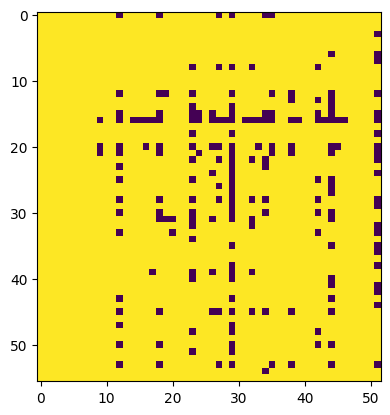

In [77]:
channel_presence_indicator_test = calculate_channel_presence(test_images_tensor)

print(channel_presence_indicator_test)
plt.imshow(channel_presence_indicator_test)

zero_imputed_tensor_test = zero_impute_channels(test_images_tensor, channel_presence_indicator_test)
# Normalize test images
test_images_tensor_normalized = (zero_imputed_tensor_test - mean) / std


In [78]:
class TestSingleChannelDataset(Dataset):
    def __init__(self, images_tensor, channel_index, transform=None):
        """
        Args:
            images_tensor (Tensor): Tensor containing all test images.
            channel_index (int): The index of the channel to use.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images_tensor = images_tensor
        self.channel_index = channel_index
        self.transform = transform

    def __len__(self):
        return self.images_tensor.shape[0]

    def __getitem__(self, idx):
        # Select the specific channel from the image
        image = self.images_tensor[idx, self.channel_index, :, :].unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image

In [79]:
test_datasets = [TestSingleChannelDataset(test_images_tensor_normalized, i) for i in range(num_channels)]
test_loaders = [DataLoader(dataset, batch_size=64, shuffle=False) for dataset in test_datasets]

In [80]:
test_features = []

for channel_index, loader in enumerate(test_loaders):
    model = ImageRegressionCNN().to(device)
    model.load_state_dict(best_models_per_channel[channel_index])
    model.eval()

    channel_predictions = []
    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            output = model(images)
            channel_predictions.append(output.cpu().numpy())

    # Concatenate and store predictions for the current channel
    channel_predictions = np.concatenate(channel_predictions, axis=0)
    test_features.append(channel_predictions)

# Combine channel-wise predictions into a single feature matrix
test_features = np.column_stack(test_features)


print(test_features.shape)

predicted_labels = best_rf.predict(test_features)
print("predicted_labels", predicted_labels)

(56, 52)
predicted_labels [ 92.47241693  86.755962    61.36601716  85.63339684  70.75022152
  80.29346483  76.75527432  79.87305081  99.73634356  65.19826858
  71.29625338  93.04486728 110.37724874 106.71991483  94.80527038
 116.33172857 102.23313199  77.67589191  93.49346769  96.07355352
  90.69428502 100.25084832  94.18692065 105.26257024 109.02094591
 102.67367959 100.67183065  80.9487438   93.21947776  88.72622628
  97.34200682  89.17938362 104.23419363  88.16431804  87.1146242
 102.49261516  82.42048073  74.95148898  83.09042547  95.98466339
 102.8013273   79.85482004  85.0789333   82.2672792   96.60486353
  96.46800238 104.46711636  96.77183152  83.32531826  60.10669041
  88.53678108  96.87226221  99.23142979 105.69708222 106.026787
 107.41719328]


In [82]:
predicted_df = pd.DataFrame(predicted_labels)

In [83]:
predicted_df.rename(columns={0: 'pred'}, inplace=True)

predicted_df['patient_no'] = predicted_df.index + 226

predicted_df = predicted_df[['patient_no', 'pred']]

print(predicted_df)
predicted_df.to_csv('/content/drive/MyDrive/pro626/submission.csv', index=False)
# save as txt
predicted_df.to_csv('/content/drive/MyDrive/pro626/submission.txt', sep='\t', index=False)

    patient_no        pred
0          226   92.472417
1          227   86.755962
2          228   61.366017
3          229   85.633397
4          230   70.750222
5          231   80.293465
6          232   76.755274
7          233   79.873051
8          234   99.736344
9          235   65.198269
10         236   71.296253
11         237   93.044867
12         238  110.377249
13         239  106.719915
14         240   94.805270
15         241  116.331729
16         242  102.233132
17         243   77.675892
18         244   93.493468
19         245   96.073554
20         246   90.694285
21         247  100.250848
22         248   94.186921
23         249  105.262570
24         250  109.020946
25         251  102.673680
26         252  100.671831
27         253   80.948744
28         254   93.219478
29         255   88.726226
30         256   97.342007
31         257   89.179384
32         258  104.234194
33         259   88.164318
34         260   87.114624
35         261  102.492615
3